In [ ]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt

# Download data from kaggle

In [ ]:
!pip install -q kaggle

In [ ]:
# download api token from: https://www.kaggle.com/settings -> and upload here:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"danielhugauf","key":"0295a67482876b6105c9689eaf93ab20"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d nguyentuannguyen/optiver-trading-at-the-close
!unzip optiver-trading-at-the-close.zip

 98% 198M/201M [00:12<00:00, 16.2MB/s]
100% 201M/201M [00:12<00:00, 16.6MB/s]
Archive:  optiver-trading-at-the-close.zip
  inflating: optiver-trading-at-the-close/.idea/.gitignore  
  inflating: optiver-trading-at-the-close/.idea/inspectionProfiles/profiles_settings.xml  
  inflating: optiver-trading-at-the-close/.idea/jupyter-settings.xml  
  inflating: optiver-trading-at-the-close/.idea/misc.xml  
  inflating: optiver-trading-at-the-close/.idea/modules.xml  
  inflating: optiver-trading-at-the-close/.idea/optiver-trading-at-the-close.iml  
  inflating: optiver-trading-at-the-close/.idea/workspace.xml  
  inflating: optiver-trading-at-the-close/example_test_files/revealed_targets.csv  
  inflating: optiver-trading-at-the-close/example_test_files/sample_submission.csv  
  inflating: optiver-trading-at-the-close/example_test_files/test.csv  
  inflating: optiver-trading-at-the-close/optiver2023/__init__.py  
  inflating: optiver-trading-at-the-close/optiver2023/competition.cpython-310-x

In [ ]:
df_train = pd.read_csv('/content/optiver-trading-at-the-close/train.csv')
df_train.shape

(5237980, 17)

#Preprocess the dataset

##Feature selection and engineering

In [ ]:
# float64 type features
columns_to_convert = ['reference_price', 'matched_size', 'far_price', 'near_price',
                      'bid_price', 'bid_size', 'ask_price', 'ask_size',
                      'wap', 'target', 'imbalance_size']
# convert to float32 to save memory
df_train[columns_to_convert] = df_train[columns_to_convert].astype('float32')

df_train.dtypes

stock_id                     int64
date_id                      int64
seconds_in_bucket            int64
imbalance_size             float32
imbalance_buy_sell_flag      int64
reference_price            float32
matched_size               float32
far_price                  float32
near_price                 float32
bid_price                  float32
bid_size                   float32
ask_price                  float32
ask_size                   float32
wap                        float32
target                     float32
time_id                      int64
row_id                      object
dtype: object

Based on data analysis, we found highly skewed datas. Applying Quantile Transformation to follow a normal distribution and drop the original ones.

In [ ]:
from sklearn.preprocessing import QuantileTransformer

quantile_transformer = QuantileTransformer(output_distribution='normal', random_state=0)
df_train['Quantile_imbalance_size'] = quantile_transformer.fit_transform(df_train['imbalance_size'].values.reshape(-1, 1)).flatten()
df_train['Quantile_far_price'] = quantile_transformer.fit_transform(df_train['far_price'].values.reshape(-1, 1)).flatten()
df_train['Quantile_bid_size'] = quantile_transformer.fit_transform(df_train['bid_size'].values.reshape(-1, 1)).flatten()
df_train['Quantile_ask_size'] = quantile_transformer.fit_transform(df_train['ask_size'].values.reshape(-1, 1)).flatten()

# original features
features = ['imbalance_size', 'far_price', 'bid_size', 'ask_size']

# drop features
df_train = df_train.drop(features, axis=1)

In [ ]:
# check the nan values
df_train.isnull().sum()

stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_buy_sell_flag          0
reference_price                220
matched_size                   220
near_price                 2857180
bid_price                      220
ask_price                      220
wap                            220
target                          88
time_id                          0
row_id                           0
Quantile_imbalance_size        220
Quantile_far_price         2894342
Quantile_bid_size                0
Quantile_ask_size                0
dtype: int64

In [ ]:
def drop_missing_values(df):
    # drop the missing values of wap
    df = df.dropna(subset=['wap'])
    return df
# drop the missing values of wap
df_train = drop_missing_values(df_train)
df_train.shape

(5237760, 17)

##Create features based on research

In [ ]:
%%time

def calc_feature_single_stock(df):
    # Feature of each stock at different time point
    # date_id
    df["date_id_week"] = df["date_id"] % 5  # Day of the week
    df["date_id_seconds"] = df["seconds_in_bucket"] % 60  # Seconds
    # volume is the sum of ask and bid size
    df_train['volume'] = df_train['Quantile_ask_size'] + df_train['Quantile_bid_size']
    df_train['volume_norm'] = (df_train['volume'] - df_train['volume'].mean()) / df_train['volume'].std()
    # The difference between the ask/bid price and the WAP can indicate market efficiency.
    df['spread'] = df['ask_price'] - df['bid_price']

    df['mid_price'] = (df['bid_price'] + df['ask_price'])/2
    # product of imbalance size and bid-ask spread
    df["price_pressure"] = df["Quantile_imbalance_size"] * (df["spread"])

    # near_price far_price
    df['near_far_ratio'] = df['near_price'] / df['Quantile_far_price']
    df['near_far_imbalance'] = (df['Quantile_far_price'] - df['near_price']) / (df['Quantile_far_price'] + df['near_price'])


    #The ratio between ask/bid and matched sizes provides insights into market liquidity and order flow:
    # A high ask-to-matched ratio suggests that there are more sellers than buyers at a given price level,
    # potentially indicating resistance to upward price movement.
    # Conversely, a low ratio implies stronger buying interest and potential support for price increases.

    df['ask_mat_ratio'] = df['Quantile_ask_size']/df['matched_size']
    df['bid_mat_ratio'] = df['Quantile_bid_size']/df['matched_size']

    # The ratio between the ask/bid price and the reference price provides insights into market sentiment:
    # - Above 1: If the ask/bid price is higher than the reference price, it suggests bullish sentiment. Sellers are demanding a premium.
    # - Below 1: If the ask/bid price is lower than the reference price, it indicates bearish sentiment. Buyers are getting a discount.
    df['ask_ref_ratio'] = df['ask_price']/df['reference_price']
    # imbalance_size matched_size
    df['auction_volume'] = df['Quantile_imbalance_size'] + df['matched_size']
    # relative imbalance between matched and total size
    df["imbalance_ratio"] = (df["Quantile_imbalance_size"] - df["matched_size"]) / (df["matched_size"] + df["Quantile_imbalance_size"])
    # cross term
    df["imbalance_continuous_ratio"] = df['Quantile_imbalance_size'] / df["volume_norm"]
    # the overall level of buying and selling in financial markets
    df['market_activity'] = df['Quantile_bid_size'] * df['bid_price'] + df['Quantile_ask_size'] * df['ask_price']
    # The difference between the ask/bid price and the WAP can indicate market efficiency.
    df['ask_wap_diff'] = df['ask_price'] - df['wap']
    # Accumulative features
    df['imbalance_buy_sell_flag_cumsum'] =  df.groupby(['stock_id','date_id'])['imbalance_buy_sell_flag'].cumsum()
    df['rolling_std_reference_price'] = df.groupby('stock_id')['reference_price'].transform(lambda x: x.rolling(window=54).std())
    df['vwap_reference_price'] = (df['wap'] * df['reference_price']).cumsum() / df['volume_norm'].cumsum()
    # statistical features at different time point
    prices = ["reference_price", "Quantile_far_price", "near_price", "ask_price", "bid_price", "wap"]
    sizes = ["matched_size", "Quantile_bid_size", "Quantile_ask_size", "Quantile_imbalance_size"]
    for func in ["mean", "std", "skew", "kurt"]:
            df[f"all_prices_{func}"] = df[prices].agg(func, axis=1)
            df[f"all_sizes_{func}"] = df[sizes].agg(func, axis=1)

    dummy_cols_list = ['imbalance_buy_sell_flag']
    dummy_names = []
    for col in dummy_cols_list:
        dummy_df = pd.get_dummies(df.loc[:, col], prefix=col, drop_first=True)
        dummy_names += dummy_df.columns.tolist()
        # drop original column
        df = df.drop(col, axis=1)
        df = pd.concat([df, dummy_df], axis=1)
    return df

df_train = calc_feature_single_stock(df_train)
df_train.tail()


<timed exec>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CPU times: user 14.9 s, sys: 2.91 s, total: 17.8 s
Wall time: 19.2 s


,stock_id,date_id,seconds_in_bucket,reference_price,matched_size,near_price,bid_price,ask_price,wap,target,...,all_prices_mean,all_sizes_mean,all_prices_std,all_sizes_std,all_prices_skew,all_sizes_skew,all_prices_kurt,all_sizes_kurt,imbalance_buy_sell_flag_0,imbalance_buy_sell_flag_1
5237975,195,480,540,1.000317,28280362.0,0.999734,1.000317,1.000434,1.000328,2.310276,...,0.830386,7070091.00,0.416020,14140180.0,-2.449488,2.0,5.999992,4.0,False,False
5237976,196,480,540,1.000643,9187699.0,1.000386,1.000643,1.000900,1.000819,-8.220077,...,0.847850,2296925.50,0.374351,4593849.0,-2.449489,2.0,5.999995,4.0,False,False
5237977,197,480,540,0.995789,12725436.0,0.995789,0.995789,0.995883,0.995797,1.169443,...,0.705909,3181358.25,0.710108,6362718.5,-2.449490,2.0,6.000000,4.0,True,False
5237978,198,480,540,0.999210,94773272.0,0.999210,0.998970,0.999210,0.999008,-1.540184,...,0.809469,23693318.00,0.464552,47386636.0,-2.449490,2.0,5.999999,4.0,False,True
5237979,199,480,540,1.002129,24073678.0,1.001494,1.002129,1.002447,1.002274,-6.530285,...,0.882249,6018420.50,0.293562,12036838.0,-2.449483,2.0,5.999975,4.0,False,False


In [ ]:
# select high correlated features
corr_matrix = df_train.corr()
corr_features_to_target = corr_matrix[abs(corr_matrix['target']) > 0.05]['target'].sort_values(ascending=False)
#OVERALL high correlated features
corr_features_to_target

target               1.000000
ask_wap_diff         0.089569
Quantile_ask_size    0.058385
Quantile_bid_size   -0.060342
Name: target, dtype: float64

In [ ]:
# select columns which are highly correlated with each other
def get_high_correlated_features(df, threshold=0.9):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return to_drop

to_drop = get_high_correlated_features(df_train, threshold=0.9)

In [ ]:
to_drop

['bid_price',
 'ask_price',
 'wap',
 'time_id',
 'volume_norm',
 'mid_price',
 'auction_volume',
 'market_activity',
 'all_prices_mean',
 'all_sizes_mean',
 'all_sizes_std',
 'all_sizes_kurt',
 'imbalance_buy_sell_flag_0']

In [ ]:
# drop the highly correlated features
df_train = df_train.drop(to_drop, axis=1)

In [ ]:
df_train.to_csv('/content/preprocessed_data.csv', index=False)

In [ ]:
import gc
gc.collect()

86

##Feature Selection

In [ ]:
%%time
from sklearn.feature_selection import RFECV
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split

train_df = df_train.drop(columns=['target'])
targets = df_train['target']
X_train, X_test, y_train, y_test = train_test_split(train_df, targets, test_size=0.2, shuffle=False)


seed = 42 # Set the seed

# Initialize the XGBRegressor with desired hyperparameters
bst_xgb = XGBRegressor(
    booster = 'gbtree',
    objective='reg:absoluteerror',
    eval_metric = 'mae',
    n_estimators = 50,
    learning_rate = 0.3,
    random_state=seed,
    verbosity=0,
    device='cuda'
)

tscv = TimeSeriesSplit(n_splits=5)
selector = RFECV(bst_xgb, min_features_to_select=1, step=5, cv=tscv, verbose=3)
selector = selector.fit(X_train, y_train)

Fitting estimator with 32 features.
Fitting estimator with 27 features.
Fitting estimator with 22 features.
Fitting estimator with 17 features.
Fitting estimator with 12 features.
Fitting estimator with 7 features.
Fitting estimator with 2 features.
Fitting estimator with 32 features.
Fitting estimator with 27 features.
Fitting estimator with 22 features.
Fitting estimator with 17 features.
Fitting estimator with 12 features.
Fitting estimator with 7 features.
Fitting estimator with 2 features.
Fitting estimator with 32 features.
Fitting estimator with 27 features.
Fitting estimator with 22 features.
Fitting estimator with 17 features.
Fitting estimator with 12 features.
Fitting estimator with 7 features.
Fitting estimator with 2 features.
Fitting estimator with 32 features.
Fitting estimator with 27 features.
Fitting estimator with 22 features.


In [ ]:
# Number of selected features
print(selector.n_features_)

# Feature names that were selected, print out the selected features
print(selector.support_)
print(selector.feature_names_in_)
for i in range(len(selector.support_)):
    if selector.support_[i]:
        print(X_train.columns[i])
# plot feature importance



7
[False False  True False False False False False False  True  True False
 False False  True False False False False False  True False False  True
 False False False False False False False  True]
['stock_id' 'date_id' 'seconds_in_bucket' 'reference_price' 'matched_size'
 'near_price' 'row_id' 'Quantile_imbalance_size' 'Quantile_far_price'
 'Quantile_bid_size' 'Quantile_ask_size' 'date_id_week' 'date_id_seconds'
 'volume' 'spread' 'price_pressure' 'near_far_ratio' 'near_far_imbalance'
 'ask_mat_ratio' 'bid_mat_ratio' 'ask_ref_ratio' 'imbalance_ratio'
 'imbalance_continuous_ratio' 'ask_wap_diff'
 'imbalance_buy_sell_flag_cumsum' 'rolling_std_reference_price'
 'vwap_reference_price' 'all_prices_std' 'all_prices_skew'
 'all_sizes_skew' 'all_prices_kurt' 'imbalance_buy_sell_flag_1']
seconds_in_bucket
Quantile_bid_size
Quantile_ask_size
spread
ask_ref_ratio
ask_wap_diff
imbalance_buy_sell_flag_1


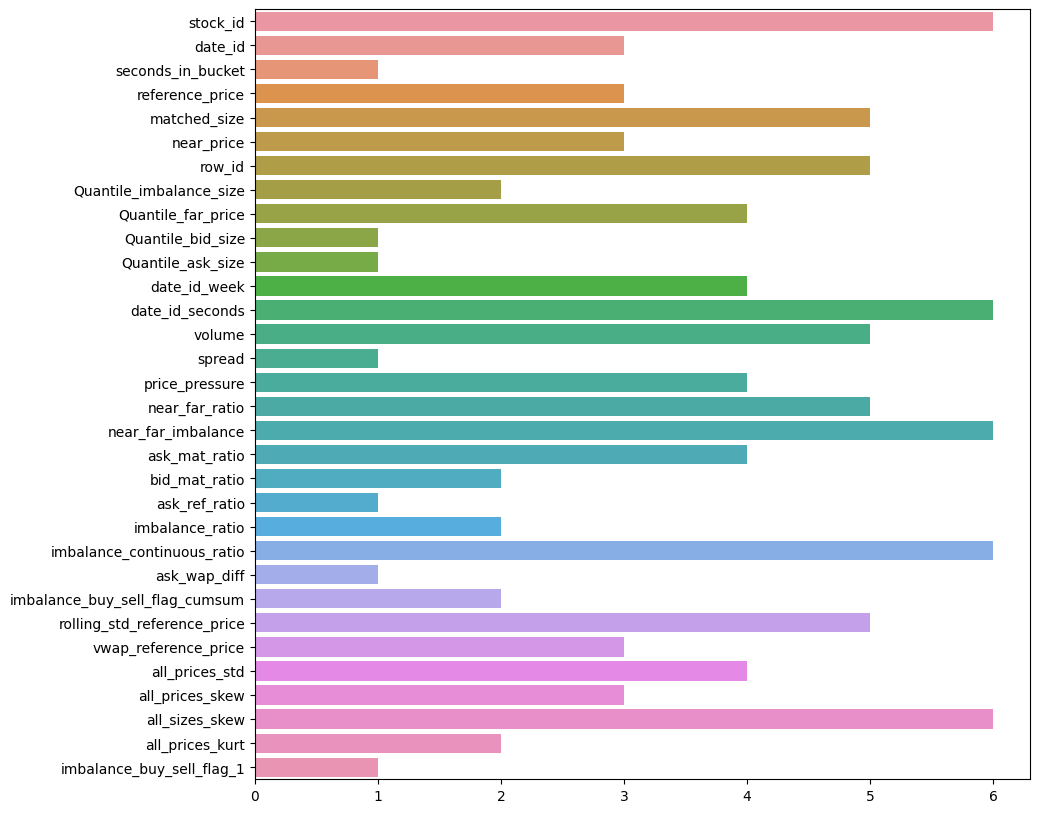

In [ ]:
# plot feature importance
plt.figure(figsize=(10, 10))
sns.barplot(x=selector.ranking_, y=X_train.columns)
plt.show()





In [ ]:

selected_features = X_train.columns[selector.support_]

selected_features

Index(['seconds_in_bucket', 'Quantile_bid_size', 'Quantile_ask_size', 'spread',
       'ask_ref_ratio', 'ask_wap_diff', 'imbalance_buy_sell_flag_1'],
      dtype='object')

In [ ]:
# add the necessary features

selected_features =  ['stock_id', 'date_id','target', 'seconds_in_bucket', 'Quantile_bid_size', 'Quantile_ask_size', 'spread',
       'ask_ref_ratio', 'ask_wap_diff', 'imbalance_buy_sell_flag_1']

In [ ]:
df = df_train[selected_features]

# save the selected features
df.to_csv('selected_features.csv', index=False)

#Or just download the preprocessed dataset

In [1]:
!pip install gdown

In [2]:
import gdown

url = 'https://drive.google.com/uc?id=1G-7Bx3YjuKR6l9EVE7RXl_dMwepMg4ci'
output = '/content/selected_features.zip'
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1G-7Bx3YjuKR6l9EVE7RXl_dMwepMg4ci
From (redirected): https://drive.google.com/uc?id=1G-7Bx3YjuKR6l9EVE7RXl_dMwepMg4ci&confirm=t&uuid=ddb01399-3bf6-4f1c-bcf5-5573d6f35a62
To: /content/selected_features.zip
100%|██████████| 132M/132M [00:00<00:00, 142MB/s]


'/content/selected_features.zip'

In [3]:
!unzip selected_features.zip

Archive:  selected_features.zip
  inflating: selected_features.csv   


#Train models

##Setup

In [4]:
import numpy as np
import pandas as pd
import random
import gc
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from lightgbm import LGBMRegressor
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV,HalvingGridSearchCV
from sklearn.metrics import mean_absolute_error
from torch.utils.data import Dataset, DataLoader, TensorDataset
import statsmodels.api as sm

In [5]:
df_train = pd.read_csv('/content/selected_features.csv')
df_train.head()
train_df = df_train.drop(columns=['target'])
targets = df_train['target']
X_train, X_test, y_train, y_test = train_test_split(train_df, targets, test_size=0.2, shuffle=False)

In [6]:
gc.collect()

11

##Hyperparam opt for XGBRegressor

In [ ]:
bst_xgb = XGBRegressor(
    booster='gbtree',
    objective='reg:absoluteerror',
    eval_metric='mae',
    random_state=42,
    verbosity=2,
    device='cuda'
)

tscv = TimeSeriesSplit(n_splits=5)

hyperparameters = {
    'n_estimators' : (50, 100, 200),
    'learning_rate': (0.001, 0.01, 0.1, 0.5),
}

score = 'neg_mean_absolute_error'
grid_search = GridSearchCV(
    bst_xgb, hyperparameters, scoring=score, cv=tscv, verbose=2
)

In [ ]:
%%time
grid_search.fit(X_train, y_train)
print(f'Grid search best MAE: {grid_search.best_score_}')

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [21:49:23] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[CV] END ...............learning_rate=0.001, n_estimators=50; total time=   4.4s
[CV] END ...............learning_rate=0.001, n_estimators=50; total time=   6.1s
[CV] END ...............learning_rate=0.001, n_estimators=50; total time=   7.0s
[CV] END ...............learning_rate=0.001, n_estimators=50; total time=  11.0s
[CV] END ...............learning_rate=0.001, n_estimators=50; total time=   9.5s
[CV] END ..............learning_rate=0.001, n_estimators=100; total time=   4.8s
[CV] END ..............learning_rate=0.001, n_estimators=100; total time=   6.1s
[CV] END ..............learning_rate=0.001, n_estimators=100; total time=   7.2s
[CV] END ..............learning_rate=0.001, n_estimators=100; total time=  12.8s
[CV] END ..............learning_rate=0.001, n_estimators=100; total time=  12.7s
[CV] END ..............learning_rate=0.001, n_estimators=200; total time=   4.8s
[CV] END ..............learning_rate=0.001, n_estimators=200; total time=   6.9s
[CV] END ..............learn

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, objective='reg:absoluteerror', ...)

{'learning_rate': 0.01, 'n_estimators': 200}

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

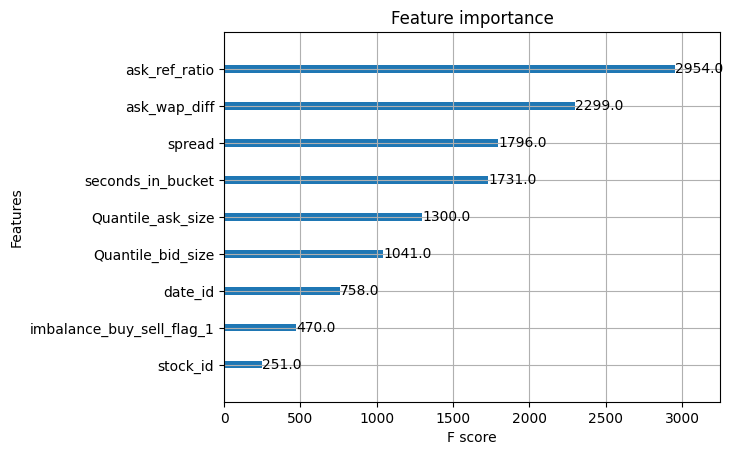

In [ ]:
display(grid_search.best_estimator_)
display(grid_search.best_params_)
xgb.plot_importance(grid_search.best_estimator_,max_num_features=30)

In [ ]:
bst_xgb = XGBRegressor(
    booster='gbtree',
    objective='reg:absoluteerror',
    eval_metric='mae',
    n_estimators=200,
    learning_rate=0.01,
    random_state=42,
    verbosity=2,
    device='cuda'
)

tscv = TimeSeriesSplit(n_splits=5)

hyperparameters = {
    'max_depth' : (3, 6, 9),
    'colsample_bynode':(0.5, 0.65, 0.8),
}

score = 'neg_mean_absolute_error'
grid_search = GridSearchCV(
    bst_xgb, hyperparameters, scoring=score, cv=tscv, verbose=2
)

In [ ]:
%%time
grid_search.fit(X_train, y_train)
print(f'Grid search best MAE: {grid_search.best_score_}')

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [18:49:26] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[CV] END ..................colsample_bynode=0.5, max_depth=3; total time=   3.9s
[CV] END ..................colsample_bynode=0.5, max_depth=3; total time=   7.2s
[CV] END ..................colsample_bynode=0.5, max_depth=3; total time=  10.1s
[CV] END ..................colsample_bynode=0.5, max_depth=3; total time=  13.2s
[CV] END ..................colsample_bynode=0.5, max_depth=3; total time=  14.5s
[CV] END ..................colsample_bynode=0.5, max_depth=6; total time=   5.7s
[CV] END ..................colsample_bynode=0.5, max_depth=6; total time=   7.0s
[CV] END ..................colsample_bynode=0.5, max_depth=6; total time=  12.6s
[CV] END ..................colsample_bynode=0.5, max_depth=6; total time=  13.7s
[CV] END ..................colsample_bynode=0.5, max_depth=6; total time=  17.3s
[CV] END ..................colsample_bynode=0.5, max_depth=9; total time=   8.4s
[CV] END ..................colsample_bynode=0.5, max_depth=9; total time=  11.9s
[CV] END ..................c

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=0.8,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, objective='reg:absoluteerror', ...)

{'colsample_bynode': 0.8, 'max_depth': 6}

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

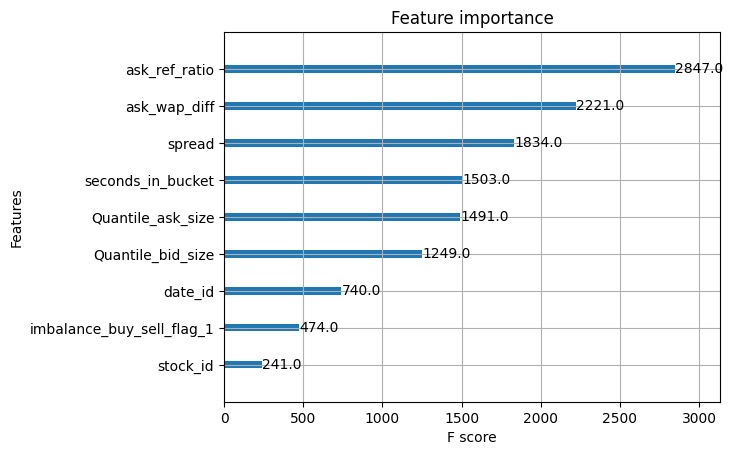

In [ ]:
display(grid_search.best_estimator_)
display(grid_search.best_params_)
xgb.plot_importance(grid_search.best_estimator_,max_num_features=30)

##Hyperparam opt for LGBMRegressor

In [ ]:
gc.collect()

0

In [ ]:
bst_lgb = LGBMRegressor(
    boosting_type = 'gbdt',
    objective='mae',
    random_state=42,
    # device= "gpu"
)

tscv = TimeSeriesSplit(n_splits=5)

hyperparameters = {
    'n_estimators': (50, 200, 600, 1000),
    'learning_rate':(0.005, 0.05, 0.5),
}

score = 'neg_mean_absolute_error'
grid_search = GridSearchCV(
    bst_lgb, hyperparameters, scoring=score, cv=tscv,verbose=3
)

In [ ]:
%%time
grid_search.fit(X_train, y_train)
print(f'Grid search best MAE: {grid_search.best_score_}')
display(grid_search.best_params_)
display(grid_search.best_estimator_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018193 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1593
[LightGBM] [Info] Number of data points in the train set: 698368, number of used features: 9
[LightGBM] [Info] Start training from score -0.050068
[CV 1/5] END learning_rate=0.005, n_estimators=50;, score=-7.123 total time=   5.8s
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.269046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1660
[LightGBM] [Info] Number of data points in the train set: 1396736, number of used features: 9
[LightGBM] [Info] Start training from score -0.050068
[CV 2/5] END learning_rate=0.005, n_estimators=50;, score=-7.117 total time=  12.4s
[LightGBM] [Info] Au

{'learning_rate': 0.05, 'n_estimators': 50}

LGBMRegressor(learning_rate=0.05, n_estimators=50, objective='mae',
              random_state=42)

CPU times: user 1h 37min 48s, sys: 13.9 s, total: 1h 38min 2s
Wall time: 1h 38min 28s


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

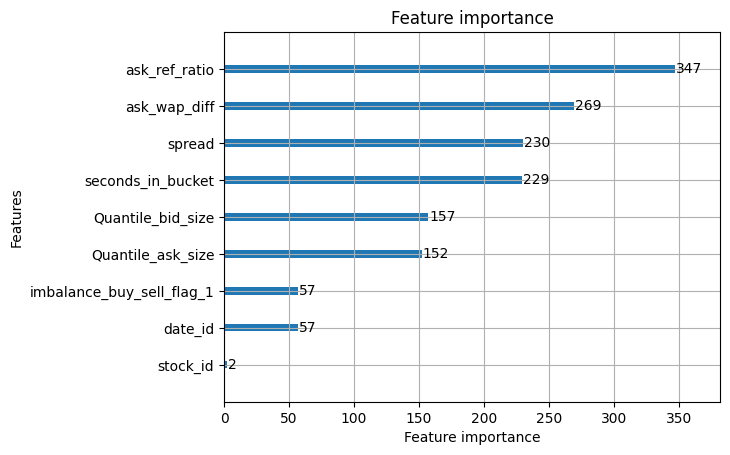

In [ ]:
lgb.plot_importance(grid_search.best_estimator_,max_num_features=25)

In [ ]:
bst_lgb = LGBMRegressor(
    boosting_type = 'gbdt',
    objective='mae',
    learning_rate = 0.05,
    n_estimators = 50,
    random_state=42,
#     device= "cuda"
)

tscv = TimeSeriesSplit(n_splits=5)

hyperparameters = {
    'num_leaves' : (30, 40, 50),
    'colsample_bytree':(0.5, 0.65, 0.8),
}

score = 'neg_mean_absolute_error'
grid_search = GridSearchCV(
    bst_lgb, hyperparameters, scoring=score, cv=tscv,verbose=3
)

In [ ]:
grid_search.fit(X_train, y_train)
print(f'Grid search best MAE: {grid_search.best_score_}')
display(grid_search.best_params_)
display(grid_search.best_estimator_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1593
[LightGBM] [Info] Number of data points in the train set: 698368, number of used features: 9
[LightGBM] [Info] Start training from score -0.050068
[CV 1/5] END colsample_bytree=0.5, num_leaves=30;, score=-7.037 total time=   7.6s
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.239213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1660
[LightGBM] [Info] Number of data points in the train set: 1396736, number of used features: 9
[LightGBM] [Info] Start training from score -0.050068
[CV 2/5] END colsample_bytree=0.5, num_leaves=30;, score=-7.042 total time=  10.1s
[LightGBM] [Info] Auto-

{'colsample_bytree': 0.8, 'num_leaves': 50}

LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, n_estimators=50,
              num_leaves=50, objective='mae', random_state=42)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

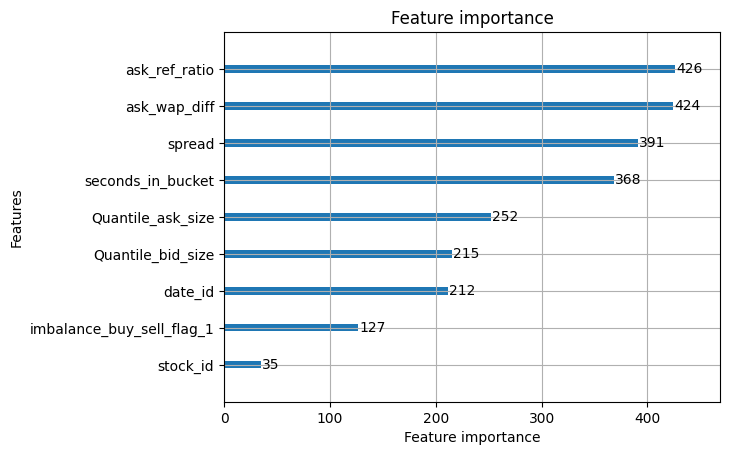

In [ ]:
lgb.plot_importance(grid_search.best_estimator_,max_num_features=25)

#Train the best models

##Train XGBRegressor

In [ ]:
gc.collect()

519

In [7]:
xgb_model = XGBRegressor(
    booster = 'gbtree',
    objective='reg:absoluteerror',
    eval_metric = 'mae',
    n_estimators = 200,
    learning_rate = 0.01,
    colsample_bynode = 0.8,
    max_depth = 6,
    random_state= 42,
    verbosity=3,
    device='cuda'
)

In [8]:
%%time
eval_set = [(X_train, y_train), (X_test, y_test)]

xgb_history = xgb_model.fit(X_train, y_train,
                            eval_set=eval_set)

[19:10:38] ======== Monitor (0): HostSketchContainer ========
[19:10:38] AllReduce: 0.014475s, 1 calls @ 14475us

[19:10:38] MakeCuts: 0.014541s, 1 calls @ 14541us

[19:10:39] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0
[19:10:39] DEBUG: /workspace/src/tree/updater_gpu_hist.cu:744: [GPU Hist]: Configure
[19:10:40] ======== Monitor (0):  ========
[19:10:40] InitCompressedData: 0.000784s, 1 calls @ 784us

[19:10:41] ======== Monitor (0):  ========
[19:10:41] InitCompressedData: 0.000296s, 1 calls @ 296us

[0]	validation_0-mae:6.49353	validation_1-mae:6.05467
[1]	validation_0-mae:6.49170	validation_1-mae:6.05334
[2]	validation_0-mae:6.48994	validation_1-mae:6.05203
[3]	validation_0-mae:6.48816	validation_1-mae:6.05076
[4]	validation_0-mae:6.48642	validation_1-mae:6.04949
[5]	validation_0-mae:6.48470	validation_1-mae:6.04824
[6]	validation_0-mae:6.48301	validation_1-mae:6.04701
[7]	validation_0-mae:6.48140	validation_1-mae:6.04582
[8]	validation_0-mae:6.47977	validation_1

##Print metrics for XGBRegressor

In [9]:
pred_y = xgb_model.predict(X_test)
mae_xgb = mean_absolute_error(y_test,pred_y)
print(f"XGBoost's MAE is {mae_xgb:.3f}")

[19:12:25] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0
[19:12:25] DEBUG: /workspace/src/tree/updater_gpu_hist.cu:744: [GPU Hist]: Configure


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [19:12:26] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


XGBoost's MAE is 5.977


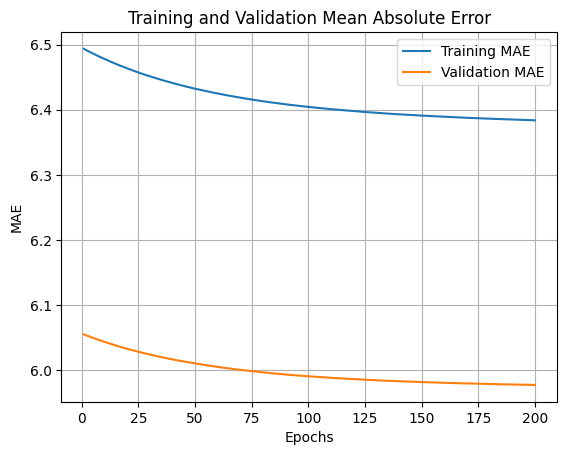

In [10]:
results = xgb_history.evals_result()
epochs = len(results['validation_0']['mae'])

# Extract the MAE information from results
train_mae = results['validation_0']['mae']
val_mae = results['validation_1']['mae']

# Plotting the training and validation MAE
plt.plot(range(1, epochs + 1), train_mae, label='Training MAE')
plt.plot(range(1, epochs + 1), val_mae, label='Validation MAE')
plt.title('Training and Validation Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()

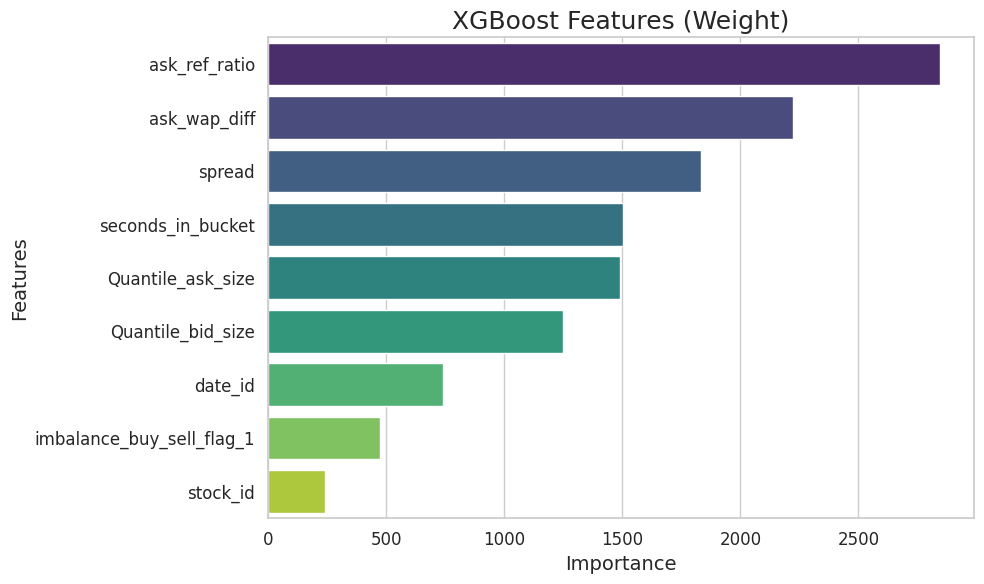

In [11]:
metric = 'weight'  # weight, gain, cover, total_gain, total_cover
imp = xgb_model.get_booster().get_score(importance_type=metric)
feature_importance = pd.DataFrame(imp, index=['score']).T.sort_values('score', ascending=False)
feature_importance.reset_index(inplace=True)
feature_importance.columns = ['Features', 'Importance']

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
f = sns.barplot(x="Importance", y="Features", data=feature_importance, hue="Features", palette="viridis", dodge=False)
f.set_xlabel("Importance", fontsize=14)
f.set_ylabel("Features", fontsize=14)
f.tick_params(labelsize=12)
plt.title(f'XGBoost Features ({metric.capitalize()})', fontsize=18)
plt.legend().set_visible(False)
plt.tight_layout()
plt.show()

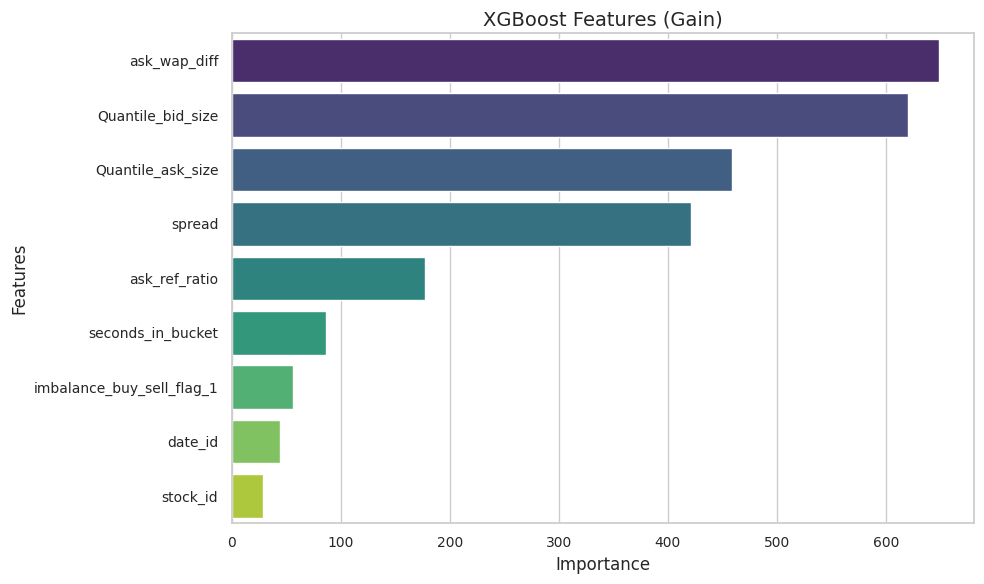

In [12]:
metric = 'gain'  # weight, gain, cover, total_gain, total_cover
imp = xgb_model.get_booster().get_score(importance_type=metric)
feature_importance = pd.DataFrame(imp, index=['score']).T.sort_values('score', ascending=False)
feature_importance.reset_index(inplace=True)
feature_importance.columns = ['Features', 'Importance']

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
f = sns.barplot(x="Importance", y="Features", data=feature_importance, hue="Features", palette="viridis", dodge=False)
f.set_xlabel("Importance", fontsize=12)
f.set_ylabel("Features", fontsize=12)
f.tick_params(labelsize=10)
plt.title(f'XGBoost Features ({metric.capitalize()})', fontsize=14)
plt.legend().set_visible(False)
plt.tight_layout()
plt.show()

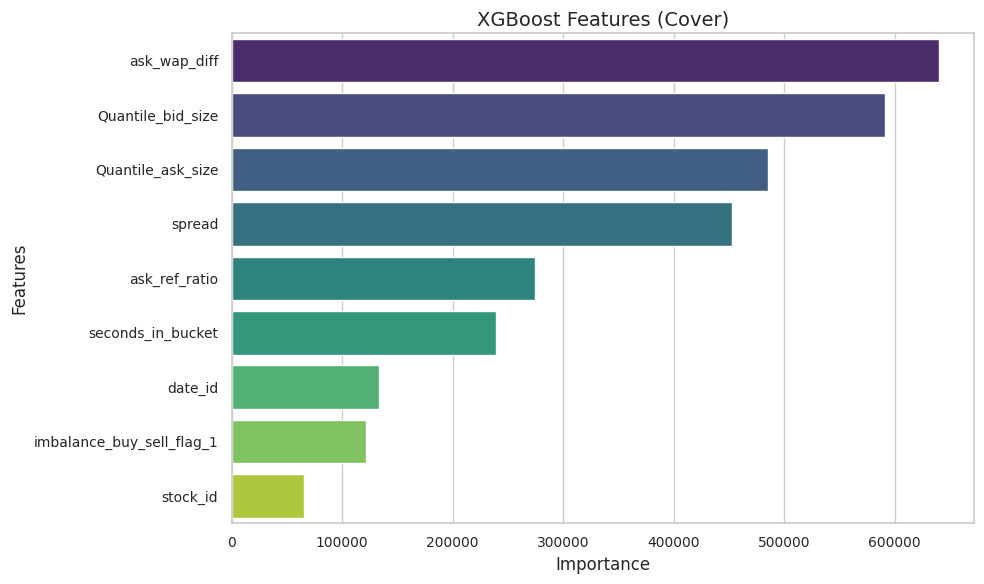

In [13]:
metric = 'cover'  # weight, gain, cover, total_gain, total_cover
imp = xgb_model.get_booster().get_score(importance_type=metric)
feature_importance = pd.DataFrame(imp, index=['score']).T.sort_values('score', ascending=False)
feature_importance.reset_index(inplace=True)
feature_importance.columns = ['Features', 'Importance']

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
f = sns.barplot(x="Importance", y="Features", data=feature_importance, hue="Features", palette="viridis", dodge=False)
f.set_xlabel("Importance", fontsize=12)
f.set_ylabel("Features", fontsize=12)
f.tick_params(labelsize=10)
plt.title(f'XGBoost Features ({metric.capitalize()})', fontsize=14)
plt.legend().set_visible(False)
plt.tight_layout()
plt.show()

##Train LGBMRegressor

In [14]:
lgb_model = LGBMRegressor(
    boosting_type = 'gbdt',
    objective='mae',
    learning_rate = 0.05,
    n_estimators = 50,
    num_leaves = 50,
    colsample_bytree = 0.8,
    random_state=42,
    verbosity=2,
) # gpu?

In [15]:
%%time
eval_set = [(X_train, y_train), (X_test, y_test)]
eval_names = ["Training MAE", "Validation MAE"]

lgb_history = lgb_model.fit(X_train, y_train,
                            eval_set=eval_set,
                            eval_names=eval_names)

[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.071191
[LightGBM] [Debug] init for col-wise cost 0.000162 seconds, init for row-wise cost 0.250151 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.103458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 1776
[LightGBM] [Info] Number of data points in the train set: 4190208, number of used features: 9
[LightGBM] [Info] Start training from score -0.069737
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 10
[LightGBM] [Debug] Trained a tree with leav

##Print metrics for LGBMRegressor

In [16]:
pred_y = lgb_model.predict(X_test)
mae_lgb = mean_absolute_error(y_test,pred_y)
print(f"LightGBM's MAE is {mae_lgb:.3f}")

LightGBM's MAE is 5.975


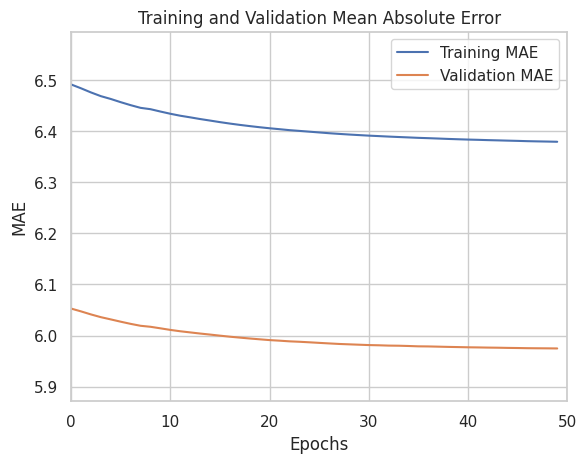

In [17]:
ax = lgb.plot_metric(lgb_model, metric='l1')  # 'l1' is equivalent to 'mae'
ax.set_title('Training and Validation Mean Absolute Error')
ax.set_xlabel('Epochs')
ax.set_ylabel('MAE')
plt.show()

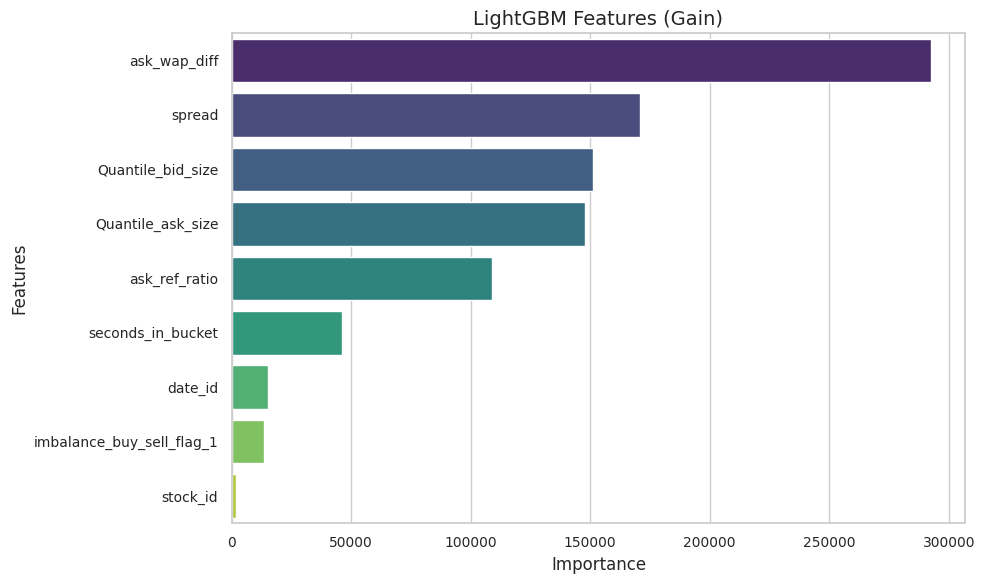

In [18]:
metric = 'gain'
imp = lgb_model.booster_.feature_importance(importance_type=metric)
features = lgb_model.booster_.feature_name()

feature_importance = pd.DataFrame(imp, index=features, columns=['score']).sort_values('score', ascending=False)
feature_importance.reset_index(inplace=True)
feature_importance.columns = ['Features', 'Importance']

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
f = sns.barplot(x="Importance", y="Features", data=feature_importance, hue="Features", palette="viridis", dodge=False)
f.set_xlabel("Importance", fontsize=12)
f.set_ylabel("Features", fontsize=12)
f.tick_params(labelsize=10)
plt.title(f'LightGBM Features ({metric.capitalize()})', fontsize=14)
plt.legend().set_visible(False)
plt.tight_layout()
plt.show()

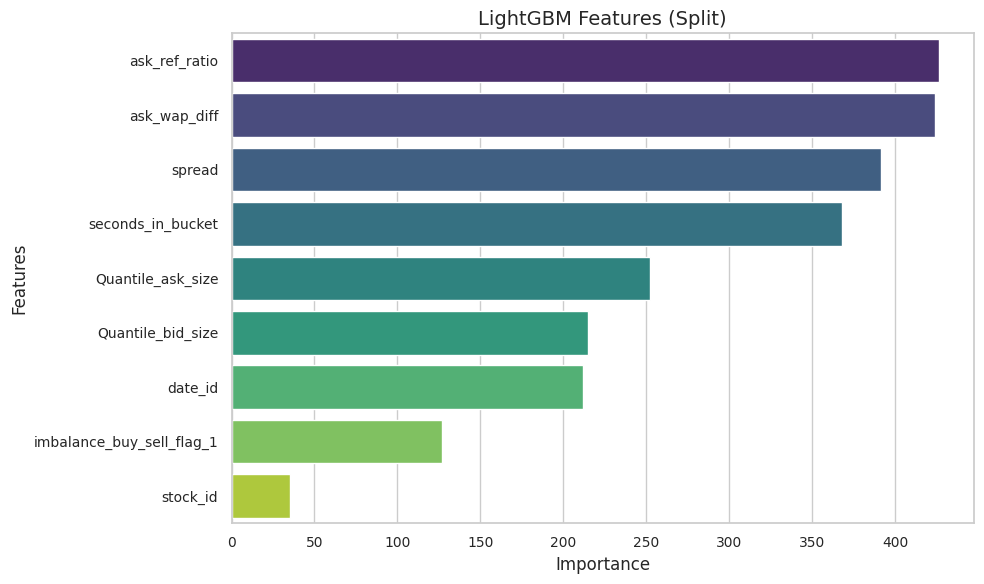

In [19]:
metric = 'split'
imp = lgb_model.booster_.feature_importance(importance_type=metric)
features = lgb_model.booster_.feature_name()

feature_importance = pd.DataFrame(imp, index=features, columns=['score']).sort_values('score', ascending=False)
feature_importance.reset_index(inplace=True)
feature_importance.columns = ['Features', 'Importance']

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
f = sns.barplot(x="Importance", y="Features", data=feature_importance, hue="Features", palette="viridis", dodge=False)
f.set_xlabel("Importance", fontsize=12)
f.set_ylabel("Features", fontsize=12)
f.tick_params(labelsize=10)
plt.title(f'LightGBM Features ({metric.capitalize()})', fontsize=14)
plt.legend().set_visible(False)
plt.tight_layout()
plt.show()

#Testing / Evaluating

In [20]:
gc.collect()

13831

In [21]:
pred_y_xgb = xgb_model.predict(X_test)
pred_y_lgb = lgb_model.predict(X_test)
print(pred_y_xgb[:5])
print(pred_y_lgb[:5])
print(y_test.head(5).values.reshape(1, -1).flatten())

[-2.27317    -0.29428405 -0.0494484  -0.1100975   0.999048  ]
[-2.23020093 -0.30072611 -0.35009921 -0.15301371  1.06228378]
[18.999577   -7.2598457   3.709793    3.3402443   0.79989433]


In [ ]:
# Plot for all of the datapoints

# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.scatter(np.arange(len(y_test)), y_test, label='Actual', alpha=0.5)
# plt.scatter(np.arange(len(pred_y_xgb)), pred_y_xgb, label='XGBoost Prediction', alpha=0.5)
# plt.title('XGBoost Predictions vs Actual')
# plt.xlabel('Data Points')
# plt.ylabel('Target Value')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.scatter(np.arange(len(y_test)), y_test, label='Actual', alpha=0.5)
# plt.scatter(np.arange(len(pred_y_lgb)), pred_y_lgb, label='LightGBM Prediction', alpha=0.5)
# plt.title('LightGBM Predictions vs Actual')
# plt.xlabel('Data Points')
# plt.ylabel('Target Value')
# plt.legend()

# plt.tight_layout()
# plt.show()

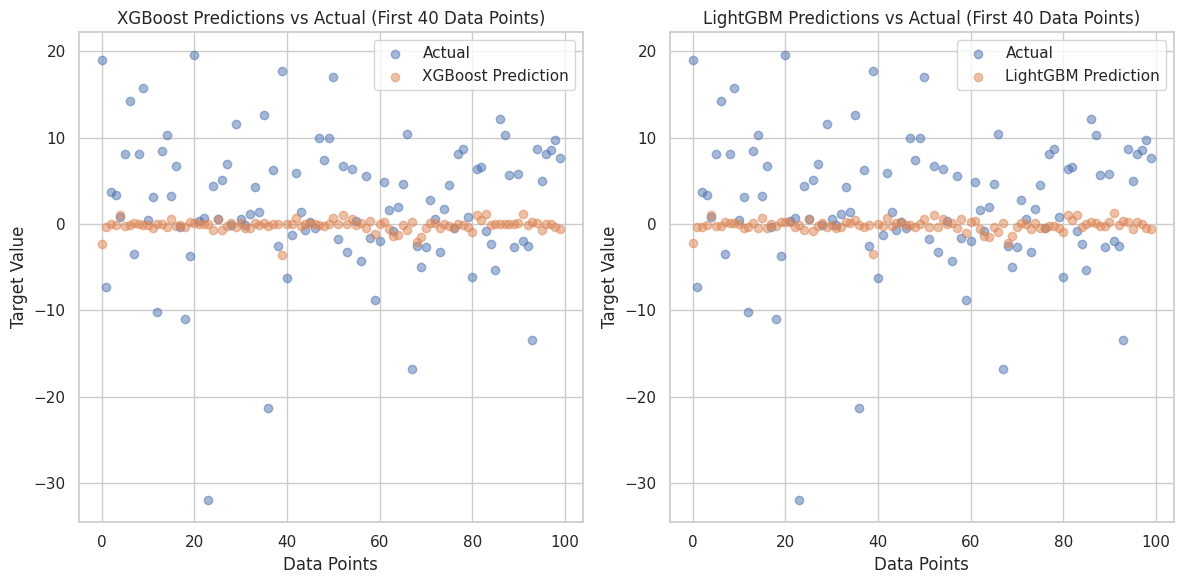

In [22]:
# Plot for the first 100 datapoints

num_points = 100

# Plotting the XGBoost predictions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(np.arange(num_points), y_test[:num_points], label='Actual', alpha=0.5)
plt.scatter(np.arange(num_points), pred_y_xgb[:num_points], label='XGBoost Prediction', alpha=0.5)
plt.title('XGBoost Predictions vs Actual (First 40 Data Points)')
plt.xlabel('Data Points')
plt.ylabel('Target Value')
plt.legend()

# Plotting the LightGBM predictions
plt.subplot(1, 2, 2)
plt.scatter(np.arange(num_points), y_test[:num_points], label='Actual', alpha=0.5)
plt.scatter(np.arange(num_points), pred_y_lgb[:num_points], label='LightGBM Prediction', alpha=0.5)
plt.title('LightGBM Predictions vs Actual (First 40 Data Points)')
plt.xlabel('Data Points')
plt.ylabel('Target Value')
plt.legend()

plt.tight_layout()
plt.show()


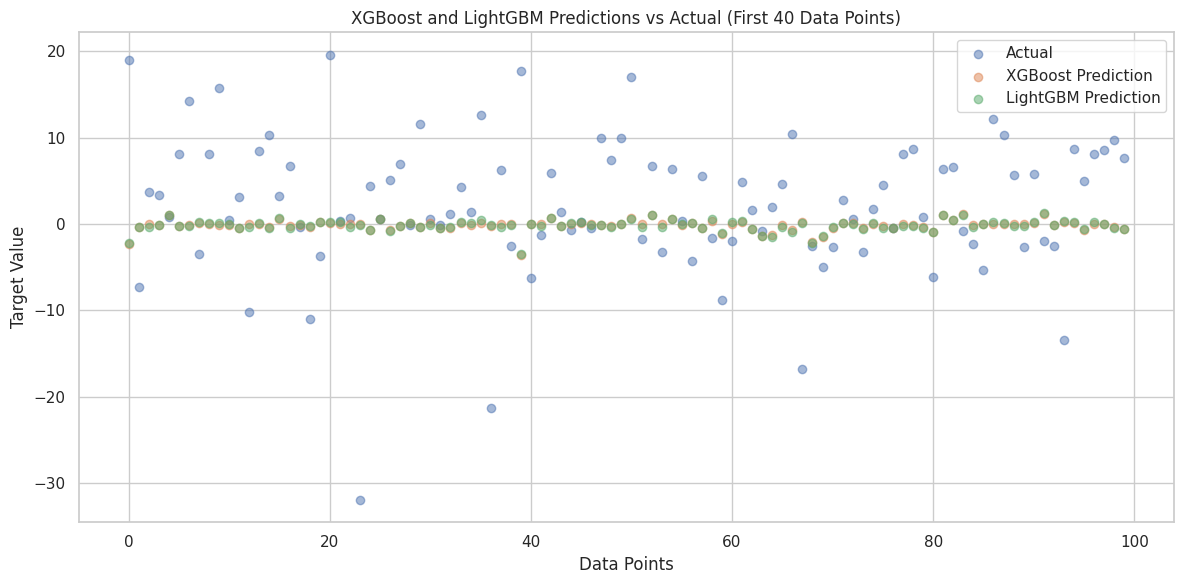

In [23]:
# Plot for the first 100 datapoints with both models on the same graph

num_points = 100

plt.figure(figsize=(12, 6))
plt.scatter(np.arange(num_points), y_test[:num_points], label='Actual', alpha=0.5)
plt.scatter(np.arange(num_points), pred_y_xgb[:num_points], label='XGBoost Prediction', alpha=0.5)
plt.scatter(np.arange(num_points), pred_y_lgb[:num_points], label='LightGBM Prediction', alpha=0.5)

plt.title('XGBoost and LightGBM Predictions vs Actual (First 40 Data Points)')
plt.xlabel('Data Points')
plt.ylabel('Target Value')
plt.legend()

plt.tight_layout()
plt.show()
